<a href="https://colab.research.google.com/github/racoope70/daytrading-with-ml/blob/main/Model_Selector_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# === IMPORTS ===
import os
import ast
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive

# === MOUNT GOOGLE DRIVE ===
drive.mount('/content/drive')

# === CONFIGURATION ===
results_dir = "/content/drive/MyDrive/Model_Selector/Results"
combined_output_path = os.path.join(results_dir, "all_models_selector_ready.csv")
output_path = os.path.join(results_dir, "best_models_by_ticker.xlsx")

# === STEP 1: DETECT & LOAD ALL CSVs IN FOLDER ===
combined_results = []

for file in os.listdir(results_dir):
    if file.endswith(".csv"):
        file_path = os.path.join(results_dir, file)
        try:
            df = pd.read_csv(file_path)
            if "Model" not in df.columns:
                model_name = file.split("_model_selector")[0].split("_results")[0].upper()
                df["Model"] = model_name
            combined_results.append(df)
            print(f"Loaded: {file}")
        except Exception as e:
            print(f"⚠️ Error loading {file}: {e}")

if not combined_results:
    raise ValueError("No valid model files loaded.")

# === STEP 2: COMBINE & SAVE CSV ===
master_df = pd.concat(combined_results, ignore_index=True)
master_df.to_csv(combined_output_path, index=False)
print(f"\n✅ Combined model selector results saved to:\n{combined_output_path}")

# === STEP 3: CLEANUP & CASTING ===
df = master_df.copy()
print(f"\n📐 Combined shape: {df.shape}")

# Parse dictionary if present
if 'Signal Map' in df.columns:
    df['Signal Map'] = df['Signal Map'].apply(
        lambda x: ast.literal_eval(x) if isinstance(x, str) and x.startswith("{") else x
    )

# Drop legacy 'score' column
if 'score' in df.columns:
    df.drop(columns=['score'], inplace=True)

# Ensure numeric
for col in ['Sharpe', 'Return', 'Accuracy']:
    df[col] = pd.to_numeric(df.get(col), errors='coerce').fillna(0)

# Drop incomplete rows
df = df[df['Ticker'].notnull() & df['Model'].notnull()]
df = df[df['Sharpe'].notna() & df['Return'].notna()]

# === STEP 4: COMPUTE COMPOSITE SCORE ===
df['Score'] = (
    df['Sharpe'] * 0.4 +
    df['Return'] * 0.3 +
    df['Accuracy'] * 0.3
)

# === STEP 5: PICK BEST MODEL PER TICKER ===
best_models = df.sort_values(['Ticker', 'Score'], ascending=[True, False]) \
                .groupby('Ticker').first().reset_index()

# === STEP 6: EXPORT RESULTS ===
best_models.to_excel(output_path, index=False)
print(f"\n📤 Saved best models by ticker to:\n{output_path}")

# === STEP 7: SUMMARY OUTPUT ===
print("\n📊 Model win count:")
print(best_models['Model'].value_counts())

print("\n🏆 Top 10 Models by Score:")
display(best_models.sort_values('Score', ascending=False).head(10))


Mounted at /content/drive
Loaded: kmeans_model_selector_metrics.csv
Loaded: ppo_model_selector_ready.csv
Loaded: lightgbn_model_selector_ready.csv
Loaded: deep_sarsa_model_selection.csv
Loaded: dqn_model_selection.csv
Loaded: sac_model_selector_ready.csv
Loaded: td3_model_selector_ready.csv
Loaded: a2c_model_selector_ready.csv
Loaded: xgboost_results.csv
Loaded: random_forest_results.csv

✅ Combined model selector results saved to:
/content/drive/MyDrive/Model_Selector/Results/all_models_selector_ready.csv

📐 Combined shape: (1254, 15)

📤 Saved best models by ticker to:
/content/drive/MyDrive/Model_Selector/Results/best_models_by_ticker.xlsx

📊 Model win count:
Model
DEEP_SARSA_MODEL_SELECTION.CSV    16
DQN_MODEL_SELECTION.CSV           12
Random Forest                      9
XGBoost                            9
A2C                                7
PPO                                4
TD3                                3
Name: count, dtype: int64

🏆 Top 10 Models by Score:


,Ticker,Final Market,Final Strategy,Sharpe,Drawdown,Final Portfolio Value,Signal Map,Model,Accuracy,Precision,Recall,F1_Score,Return,Final_Portfolio,Score
14,CSCO,1.315539,1.033037,0.4021,6.8632,0.039296,"{0: 'Buy', 1: 'Hold'}",DEEP_SARSA_MODEL_SELECTION.CSV,0.4891,NaN,NaN,NaN,568.65000,668653.99,170.902570
46,PM,1.692659,1.692659,1.1104,1.2128,0.550009,{1: 'Buy'},DQN_MODEL_SELECTION.CSV,0.4584,NaN,NaN,NaN,489.48000,589482.26,147.425680
33,MCD,1.164775,1.255706,0.4135,2.7183,0.262660,"{2: 'Buy', 1: 'Hold', 0: 'Sell'}",DQN_MODEL_SELECTION.CSV,0.5038,NaN,NaN,NaN,388.96000,488955.39,117.004540
52,TSLA,2.000457,1.316891,0.6435,6.8257,0.891878,"{2: 'Buy', 0: 'Hold', 1: 'Sell'}",DEEP_SARSA_MODEL_SELECTION.CSV,0.2042,NaN,NaN,NaN,275.76000,375756.58,83.046660
2,ABT,1.285455,1.365139,0.6516,1.5743,0.395444,"{0: 'Buy', 1: 'Hold', 2: 'Sell'}",DEEP_SARSA_MODEL_SELECTION.CSV,0.3041,NaN,NaN,NaN,214.37000,314366.47,64.662870
3,ACN,1.031623,0.852035,0.4020,21.6223,-0.092967,"{0: 'Buy', 2: 'Hold', 1: 'Sell'}",DQN_MODEL_SELECTION.CSV,0.0467,NaN,NaN,NaN,194.65000,294654.12,58.569810
35,META,1.352936,1.097718,0.7370,18.7100,0.133299,"{0: 'Buy', 1: 'Hold'}",PPO,0.0000,NaN,NaN,NaN,190.34433,290344.33,57.398099
58,WMT,1.535156,1.535156,0.8429,1.4646,0.454244,{1: 'Buy'},DEEP_SARSA_MODEL_SELECTION.CSV,0.4475,NaN,NaN,NaN,183.48000,283481.44,55.515410
50,T,NaN,NaN,0.8231,0.6802,NaN,None,DEEP_SARSA_MODEL_SELECTION.CSV,0.5154,NaN,NaN,NaN,179.10000,279100.75,54.213860
24,IBM,1.577773,1.307281,0.7276,1.2428,0.295814,"{1: 'Buy', 0: 'Hold'}",DEEP_SARSA_MODEL_SELECTION.CSV,0.5391,NaN,NaN,NaN,174.34000,274341.32,52.754770


<Figure size 1400x600 with 0 Axes>

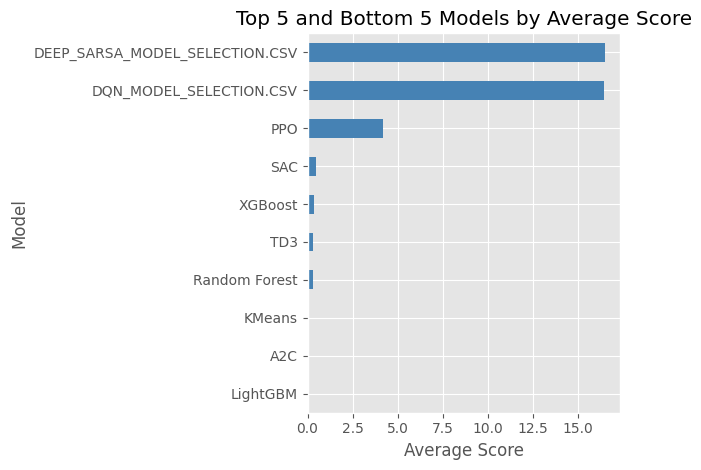

<Figure size 1200x600 with 0 Axes>

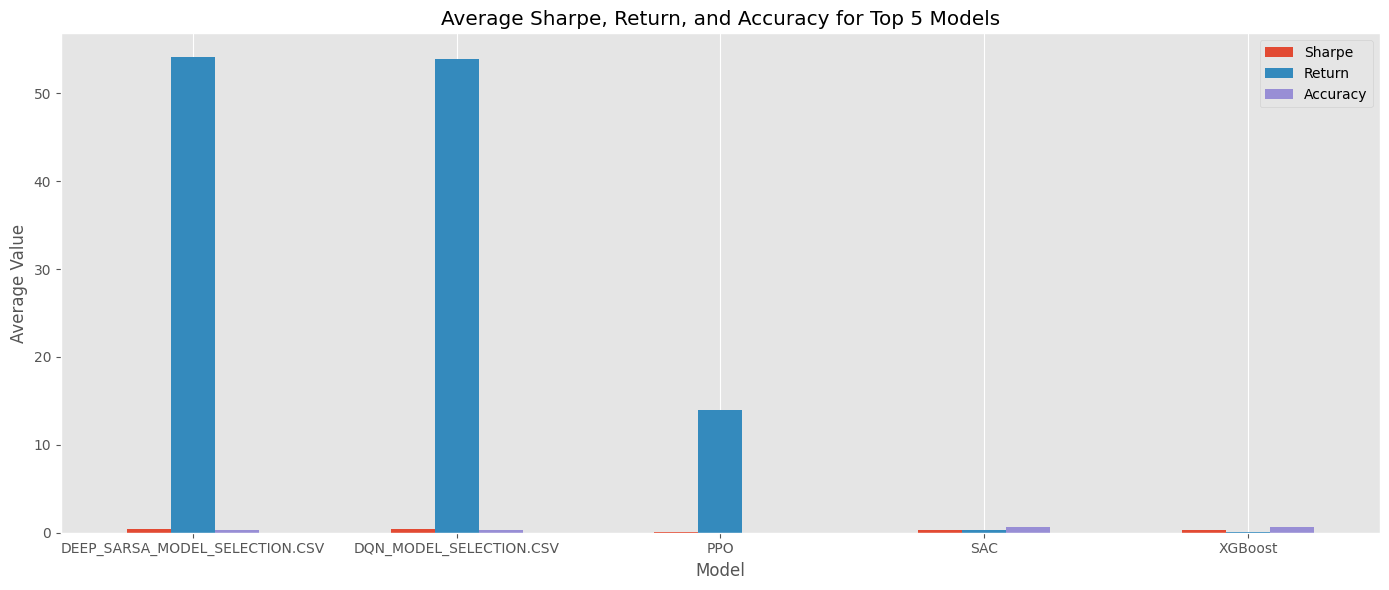

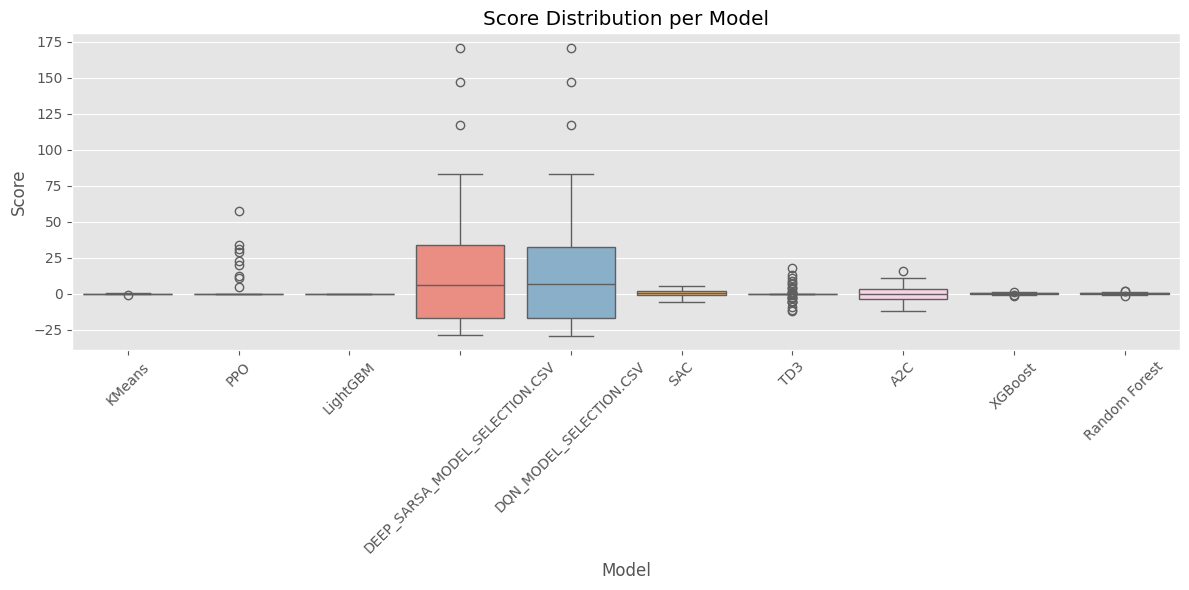

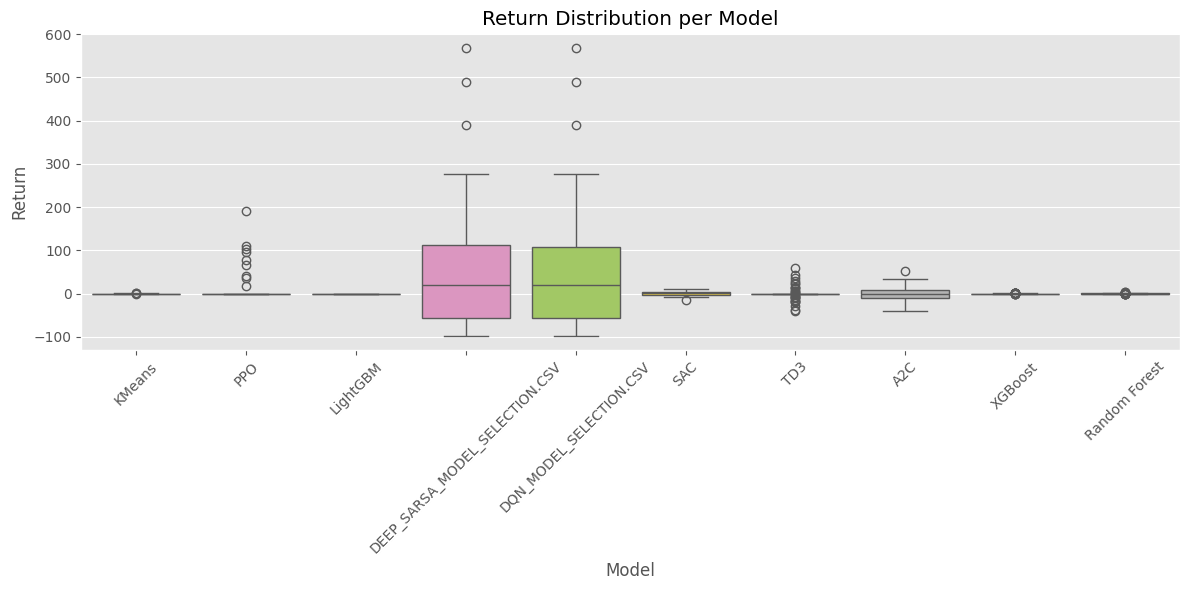

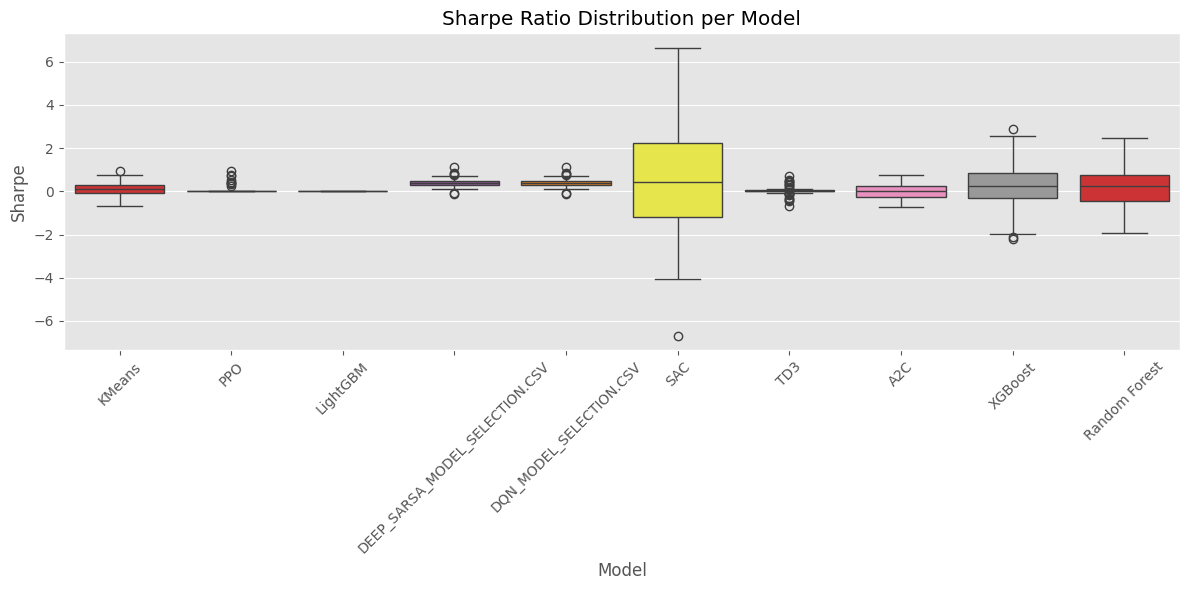

In [4]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# === Ensure numeric types for plotting ===
for col in ['Sharpe', 'Return', 'Accuracy', 'Score']:
    df[col] = pd.to_numeric(df.get(col), errors='coerce').fillna(0)

# === Compute model averages ===
model_means = df.groupby("Model")[['Sharpe', 'Return', 'Accuracy', 'Score']].mean().sort_values("Score", ascending=False)

# === Select Top 5 and Bottom 5 Models ===
top5_models = model_means.head(5)
bottom5_models = model_means.tail(5)

# === Combine for Top & Bottom Chart ===
top_bottom_combined = pd.concat([top5_models, bottom5_models])

# === Plot 1: Top & Bottom 5 Models by Average Score ===
plt.figure(figsize=(14, 6))
top_bottom_combined[['Score']].sort_values("Score").plot(kind='barh', legend=False, color='steelblue')
plt.title("Top 5 and Bottom 5 Models by Average Score")
plt.xlabel("Average Score")
plt.grid(True)
plt.tight_layout()
plt.show()

# === Plot 2: Average Metric Comparison (Top 5 only) ===
plt.figure(figsize=(12, 6))
top5_models[['Sharpe', 'Return', 'Accuracy']].plot(kind='bar', figsize=(14, 6))
plt.title("Average Sharpe, Return, and Accuracy for Top 5 Models")
plt.ylabel("Average Value")
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# === Plot 3: Score Distribution per Model ===
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x="Model", y="Score", hue="Model", palette="Set3", dodge=False)
plt.title("Score Distribution per Model")
plt.legend([],[], frameon=False)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# === Plot 4: Return Distribution per Model ===
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x="Model", y="Return", hue="Model", palette="Set2", dodge=False)
plt.title("Return Distribution per Model")
plt.legend([],[], frameon=False)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# === Plot 5: Sharpe Ratio Distribution per Model ===
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x="Model", y="Sharpe", hue="Model", palette="Set1", dodge=False)
plt.title("Sharpe Ratio Distribution per Model")
plt.legend([],[], frameon=False)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
